# DISPLAY RESULTS

In [174]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import numpy as np 
from matplotlib.ticker import MaxNLocator, MultipleLocator

from envs.minigrid import GridWorldEnv
from envs.modules import get_l2_distance, astar
import warnings

In [175]:
def retrieve_df_data_from_folder_path(folder_path,model_name, nav_type, load_model=False):
    df_list = []
    filepath_list = []
    i=0
    
    for dirpath, dirnames, filenames in os.walk(folder_path):
        #print(model_name+'.pkl' in dirpath.split('/')[-1], dirpath.split('/')[-1], model_name)
        # print('I want : True, True, pkl in modelname ')

        if len(dirnames) != 0:  # Skip directories that contain subdirectories
            continue
        elif nav_type == 'goal' and 'cscg' in model_name and 'blank' in model_name:
            pass
        elif nav_type == 'goal' and 'cscg' in model_name and not model_name+'.pkl' in dirpath.split('/')[-1]:
            continue
        #We want a model as prior
        elif nav_type == 'goal' and 'ours' in model_name and load_model and not model_name+'.pkl' in dirpath.split('/')[-1]:
            continue
        #Vanilla model
        elif nav_type == 'goal' and 'ours' in model_name and not load_model and model_name+'.pkl' in dirpath.split('/')[-1]:
            continue
        i+=1
        #print('dirpath', dirpath,i)
     
        for file in filenames:
            if file.endswith('.xlsx'):
                
                file_path = os.path.join(dirpath, file)
                try:
                    
                    # I expect to see RuntimeWarnings in this block
                    with warnings.catch_warnings():
                        warnings.filterwarnings('ignore',category=RuntimeWarning)
                        # warnings.simplefilter("ignore", category=RuntimeWarning)
                        df = pd.read_excel(file_path)
                        df_list.append(df)
                
                    filepath_list.append(dirpath)
                   
                    
                except pd.errors.ParserError as e:
                    print(f"Skipping file {file_path} due to ParserError: {e}")

    return df_list, filepath_list

In [176]:
possible_actions = {'LEFT':0, 'RIGHT':1, 'UP':2, 'DOWN':3, 'STAY':4}
colors = ['green', 'darkgreen', 'orange', 'gold', 'cyan', 'blue', 'purple', 'grey', 'pink', 'indianred']

In [177]:
def min_steps_to_visit_all_rooms(rooms, pose):
    desired_poses = [coord for coord in ((i, j) for i in range(rooms.shape[0]) \
                                for j in range(rooms.shape[1]) if rooms[i, j] != -1)]
    
    # print('desired_poses', desired_poses)
    distance = 0
    desired_poses.remove(pose)

    while len(desired_poses) > 0:
        all_relative_dists = []
        for r, c in desired_poses:
            relative_dist = get_l2_distance(r, pose[0], c, pose[1])
            all_relative_dists.append(relative_dist)
        if len(all_relative_dists) == 0:
            return distance
        closest_goal_idx = np.argmin(all_relative_dists)
        path = astar(rooms, pose, desired_poses[closest_goal_idx] )
        pose = path[-1]
        distance += len(path) -1
        # print('before',len(desired_poses))
        desired_poses = [pose for pose in desired_poses if pose not in path]
        # print('after' ,len(path)-1, len(desired_poses))
    return distance

In [178]:
#BAR PLOTS AVERAGE_STEPS
def bar_plot(data, group, data_name, group_name, model_names):
    num_groups = len(set(group))
    fig_width = max(5, num_groups * 0.9) 
    width = 0.7 / (len(data) )
    bar_pose = -0.7 / (len(data) )
    plt.grid(axis='y', alpha=0.5, zorder=0)

    
    x = np.arange(len(group)) 
    for id, model in enumerate(data):
        # plot data in grouped manner of bar type 
        # print(x + bar_pose, len(model),width )
        plt.bar(x + bar_pose, model, width, color=colors[id], zorder=2) 
        bar_pose += 0.7 / (len(data) )
    plt.xticks(x, group) 
    plt.xlabel(group_name) 
    plt.ylabel(data_name) 
    plt.legend(model_names, loc='lower left')#, bbox_to_anchor=(1.3, 0.99)) 
    
    # Add additional ticks to the y-axis
    # if plt.ylim()[1] + 1 > 120:
    #     y_tick = np.arange(plt.ylim()[0], 120, 20)
    #     y_tick= np.append(y_tick,np.arange(120, plt.ylim()[1] + 1, 50))
    # else:
    #     y_tick = np.arange(plt.ylim()[0], plt.ylim()[1] + 1, 20)
    # print(y_tick)
    # plt.yticks(y_tick)
    plt.yscale('symlog')

    #EXPLORATION ALL ROOMS VISITED ONCES STEPS
    # plt.yticks([10, 20, 50, 100, 200, 500, 650], [10, 20, 50, 100, 200, 500, 650])
    # y_ticks = np.linspace(10, (plt.ylim()[1]+1)/3, num=5)
    # y_ticks_2 = np.linspace((plt.ylim()[1]+1)/3, (plt.ylim()[1]+5), num=4)
    # y_ticks = np.append(y_ticks, y_ticks_2[1:])
    # y_ticks = np.round(y_ticks / 5).astype(int) * 5

    #EXPLORATION ALL STEPS
    y_ticks = np.linspace(10, (plt.ylim()[1]+1)/7, num=5)
    y_ticks_2 = np.linspace((plt.ylim()[1]+1)/7, (plt.ylim()[1]+5), num=6)
    y_ticks = np.append(y_ticks, y_ticks_2[1:])
    y_ticks = np.round(y_ticks / 5).astype(int) * 5
    y_ticks = np.insert(y_ticks,1, 20)
    print(y_ticks)
    plt.yticks(y_ticks, y_ticks)

    # Calculate figure size based on number of unique groups
    fig_width = max(8, num_groups * 0.9)  
    fig_height = 6
    plt.gcf().set_size_inches(fig_width, fig_height)
    
    plt.savefig('figures/' + data_name + '_models_per_' + group_name + '.jpg')
    plt.show()


In [179]:
#BAR PLOTS AVERAGE_STEPS WITH STD
def bar_plot_wt_std(data, std_data, group, data_name, group_name, model_names):
    num_groups = len(set(group))
    fig_width = max(5, num_groups * 0.9) 
    width = 0.7 / (len(data) )
    bar_pose = -0.7 / (len(data) )
    plt.grid(axis='y', alpha=0.5, zorder=0)

    colors = ['green', 'darkgreen', 'orange', 'gold', 'cyan', 'blue', 'purple', 'grey', 'pink', 'indianred']
    x = np.arange(len(group)) 
    for id, (model, model_std) in enumerate(zip(data, std_data)):
        plt.bar(x + bar_pose, model, yerr=model_std, width=width, color=colors[id], zorder=2) 
        bar_pose += 0.7 / (len(data) )
    x = [i+0.2 for i in x]
    plt.xticks(x, group, fontsize=13) 
    plt.xlabel(group_name, fontsize=17) 
    plt.ylabel(data_name, fontsize=17) 
    # plt.legend(model_names, loc='lower left', fontsize=20)#, bbox_to_anchor=(1.3, 0.99)) 
    
    # Add additional ticks to the y-axis
    # if plt.ylim()[1] + 1 > 120:
    #     y_tick = np.arange(plt.ylim()[0], 120, 20)
    #     y_tick= np.append(y_tick,np.arange(120, plt.ylim()[1] + 1, 50))
    # else:
    #     y_tick = np.arange(plt.ylim()[0], plt.ylim()[1] + 1, 20)
    # print(y_tick)
    # plt.yticks(y_tick)
    plt.yscale('symlog')

    #EXPLORATION ALL ROOMS VISITED ONCES STEPS
    # plt.yticks([10, 20, 50, 100, 200, 500, 650], [10, 20, 50, 100, 200, 500, 650], fontsize=13)
    plt.yticks([10, 15, 20, 50, 70, 100, 140,200, 300, 500], [10, 15, 20, 50, 70,100,140, 200, 300, 500], fontsize=13)
    y_ticks = np.linspace(10, (plt.ylim()[1]+1)/3, num=5)
    y_ticks_2 = np.linspace((plt.ylim()[1]+1)/3, (plt.ylim()[1]+5), num=4)
    y_ticks = np.append(y_ticks, y_ticks_2[1:])
    y_ticks = np.round(y_ticks / 5).astype(int) * 5

    #EXPLORATION ALL STEPS
    # y_ticks = np.linspace(10, (plt.ylim()[1]+1)/7, num=5)
    # y_ticks_2 = np.linspace((plt.ylim()[1]+1)/7, (plt.ylim()[1]+5), num=6)
    # y_ticks = np.append(y_ticks, y_ticks_2[1:])
    # y_ticks = np.round(y_ticks / 5).astype(int) * 5
    # y_ticks = np.insert(y_ticks,1, 20)
    # print(y_ticks)
    # plt.yticks(y_ticks, y_ticks)

    # Calculate figure size based on number of unique groups
    fig_width = max(13, num_groups * 0.9)  
    fig_height = 10
    plt.gcf().set_size_inches(fig_width, fig_height)
    
    plt.savefig('figures/' + data_name + '_models_per_' + group_name + '.jpg')
    plt.show()


In [180]:
def get_short_term_goal(env, input=None):
    if input is None:
        start_pose = env.curr_loc
    elif isinstance(input, dict):
        start_pose = input['pose_pred']
    else:
        raise ValueError('get_short_term_goal:Input type not recognised ' + str(type(input)))

    output = [0,0,0]
    goal_poses_row, goal_poses_col = env.get_goal_position(env.goal_ob)
    all_relative_dists = []
    for r, c in zip(goal_poses_row,goal_poses_col):
        relative_dist = get_l2_distance(r, start_pose[0], c, start_pose[1])
        all_relative_dists.append(relative_dist)
    if len(all_relative_dists) == 0:
        #Goal not in env
        return None
    closest_goal_idx = np.argmin(all_relative_dists)
    
    goal_row = goal_poses_row[closest_goal_idx]
    goal_col = goal_poses_col[closest_goal_idx]
    print('start_pose', start_pose,'(goal_row, goal_col)', (goal_row, goal_col))
    path = astar(env.rooms, start_pose, (goal_row, goal_col))
    print('path', path)
    if path == None:
        return None
    output[0] = int((0%360.)/5.) #angle
    output[1] = len(path) -1 #step dist
    output[2] = path #gt path #NB: might not be the unique best path
    return output

## Average Steps

### Agglomerate data

In [9]:
#TEST AGLOMERATE DATA
# env = 'grid_3x3'
model_name = 'ours_v3'
nav_type = 'goal'
if 'ours' in model_name:
    who = 'ours'
else:
    who = 'cscg'

# Set the path to the folder containing the excel files
if nav_type == 'exploration':
    folder_path = 'results/'+ env +'/' + who+'_'+ nav_type +'/' + model_name
else:
    folder_path = 'results/'+ env +'/' + who+'_'+ nav_type

print(folder_path)

df_list, filepath_list = retrieve_df_data_from_folder_path(folder_path,model_name, nav_type)
combined_df = pd.concat(df_list)
# print(len(df_list))
# # Write the combined DataFrame to a new excel file
combined_df.to_excel('results/' + env+'_'+model_name+'_'+ nav_type +'_combined.xlsx', index=False)


NameError: name 'env' is not defined

### exploration

In [181]:
#GET AVERAGE STEPS PERFECT TRANSITION PER MODEL AND ENVS
envs = ['grid_3x3', 'grid_3x3_alias', 'grid_4x4', 'grid_4x4_alias', 'grid_t_maze','grid_t_maze_alias', 'grid_donut']
model_names = ['cscg_random_policy', 'cscg', 'cscg_pose_ob_random_policy', 'cscg_pose_ob', 'ours_v4_2_MMP','ours_v4_2_VANILLA' ]
nav_type = 'exploration'

average_steps = [[0]*(len(envs)) for _ in range(len(model_names)+1)]
std_steps = [[0]*(len(envs)) for _ in range(len(model_names)+1)]
for id_m, model_name in enumerate(model_names):
    for id_e, env in enumerate(envs):
        a_failure = 0
        # i = 0
        average_steps_model = []
        # Set the path to the folder containing the excel files
        if 'ours' in model_name:
            who = 'ours'
        else:
            who = 'cscg'
        folder_path = 'results/'+ env +'/' + who+'_'+ nav_type +'/' + model_name
        df_list, filepath_list = retrieve_df_data_from_folder_path(folder_path,model_name, nav_type)
        print('model', model_name, 'env', env,'number of tests:', len(df_list))
        for df, filepath in zip(df_list,filepath_list):
            headers = list(df.columns.values)
            stop_condition_header = [s for s in headers if 'stop_condition_' in s][0]
            # i+=1
            if df[stop_condition_header][0] == True:
                average_steps_model.append(len(df['steps'])-1)
            else:
                a_failure+=1
                print('failure ', filepath)
        print('average_steps_model', average_steps_model, len(average_steps_model))
        print('there is ', a_failure, ' failures over', len(filepath_list), 'models')
        average_steps[id_m][id_e] = np.mean(average_steps_model)
        std_steps[id_m][id_e] = np.std(average_steps_model)
        print()
        if len(filepath_list) == 0:
            continue
        #print('model', model_name,id_m, 'env', env, np.mean(average_steps_model))
        #THIS ASSUMES WE HAVE SQUARED ENVS
        if 'x' in env:
            dim_env = [substring for substring in env.split('_') if 'x' in substring][0]
            average_steps[-1][id_e] =  int(dim_env[-1]) * 4 -1
        else:
            env_setup = GridWorldEnv(env, {})
            if isinstance(average_steps[-1][id_e], int):
                average_steps[-1][id_e] = []
            # print('pose', df['poses'][0], type(df['poses'][0]), type(eval(df['poses'][0])))
            average_steps[-1][id_e].append(min_steps_to_visit_all_rooms(env_setup.rooms, eval(df['poses'][0])))
            
            
model_names.append('oracle')
for id_m, model_name in enumerate(model_names):
    for id_e, env in enumerate(envs):
        if isinstance(average_steps[-1][id_e], list):
            print(env, 'average_steps[-1][id_e]', average_steps[-1][id_e])
            average_steps[-1][id_e] = np.mean(average_steps[-1][id_e])
            std_steps[-1][id_e] = np.std(average_steps[-1][id_e])
print(average_steps)

model cscg_random_policy env grid_3x3 number of tests: 12
average_steps_model [170, 340, 215, 180, 260, 180, 205, 205, 195, 210, 225, 190] 12
there is  0  failures over 12 models

model cscg_random_policy env grid_3x3_alias number of tests: 13
failure  results/grid_3x3_alias/cscg_exploration/cscg_random_policy/cscg_random_policy_2024-02-16-14-42-43
failure  results/grid_3x3_alias/cscg_exploration/cscg_random_policy/cscg_random_policy_2024-02-16-14-41-46
failure  results/grid_3x3_alias/cscg_exploration/cscg_random_policy/cscg_random_policy_2024-02-19-10-40-27
failure  results/grid_3x3_alias/cscg_exploration/cscg_random_policy/cscg_random_policy_2024-02-16-14-44-40
failure  results/grid_3x3_alias/cscg_exploration/cscg_random_policy/cscg_random_policy_2024-02-19-10-41-23
average_steps_model [365, 315, 325, 330, 380, 315, 380, 300] 8
there is  5  failures over 13 models

model cscg_random_policy env grid_4x4 number of tests: 14
failure  results/grid_4x4/cscg_exploration/cscg_random_policy/

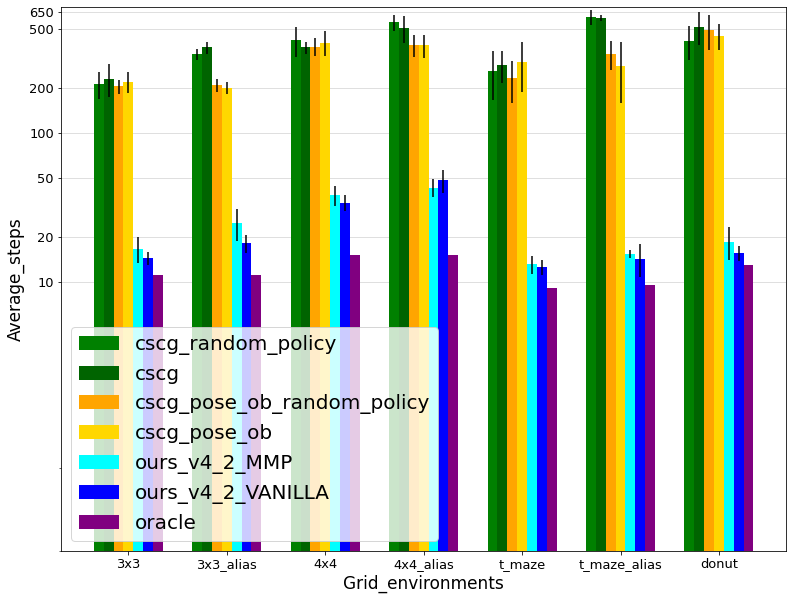

In [129]:
#BAR PLOTS AVERAGE_STEPS
envs_names = [env.replace('grid_', '') for env in envs]
bar_plot_wt_std(average_steps, std_steps, envs_names, 'Average_steps', 'Grid_environments', model_names)

In [125]:
#GET AVERAGE STEPS DISCOVERED ALL STATES PER MODEL AND ENVS
# envs = ['grid_3x3', 'grid_3x3_alias', 'grid_4x4', 'grid_4x4_alias', 'grid_t_maze', 'grid_t_maze_alias', 'grid_donut'] #
# model_names = ['cscg_random_policy', 'cscg', 'cscg_pose_ob_random_policy', 'cscg_pose_ob', 'ours_v4_VANILLA','ours_v4_MMP'] # 

envs = envs = ['grid_3x3', 'grid_3x3_alias', 'grid_4x4', 'grid_4x4_alias', 'grid_t_maze','grid_t_maze_alias', 'grid_donut']
model_names = ['cscg_random_policy', 'cscg', 'cscg_pose_ob_random_policy', 'cscg_pose_ob', 'ours_v4_2_MMP','ours_v4_2_VANILLA' ]
nav_type = 'exploration'

average_steps_first_visit = [[0]*(len(envs)) for _ in range(len(model_names)+1)]
std_steps_first_visit = [[0]*(len(envs)) for _ in range(len(model_names)+1)]

for id_m, model_name in enumerate(model_names):
    for id_e, env in enumerate(envs):
             
        average_steps_model = []
        # Set the path to the folder containing the excel files
        if 'ours' in model_name:
            who = 'ours'
        else:
            who = 'cscg'
        folder_path = 'results/'+ env +'/' + who+'_'+ nav_type +'/' + model_name
        df_list, filepath_list = retrieve_df_data_from_folder_path(folder_path,model_name, nav_type)
        print('model', model_name, 'env', env,'number of tests:', len(df_list))
             
        for i, df in enumerate(df_list):
            #Get n_rooms
            if 'x' in env:
                dim_env = [substring for substring in env.split('_') if 'x' in substring][0]
                width_dim_env = int(dim_env[-1])
                height_dim_env = int(dim_env[0])
                n_rooms = width_dim_env* height_dim_env   
                average_steps_first_visit[-1][id_e] = n_rooms -1    
            else:
                env_setup = GridWorldEnv(env, {})
                start_pose = eval(df['poses'][0])
                ob = env_setup.get_ob_given_p(start_pose)
                if ob == -1:
                    continue
                n_rooms = len(np.where(env_setup.rooms > -1)[0])  

            pose_list = []
            for n_steps, pose in enumerate(df['poses']):
                if pose not in pose_list:
                    pose_list.append(pose)
                    if len(pose_list) == n_rooms:
                        average_steps_model.append(n_steps)
                        #print('model', model_name,id_m, 'env', env, np.mean(average_steps_model))
                        if not 'x' in env :
                            if isinstance(average_steps_first_visit[-1][id_e], int):
                                average_steps_first_visit[-1][id_e] = []
                            average_steps_first_visit[-1][id_e].append(min_steps_to_visit_all_rooms(env_setup.rooms, eval(df['poses'][0]))) 
                        break
       
        average_steps_first_visit[id_m][id_e] = np.mean(average_steps_model)
        std_steps_first_visit[id_m][id_e] = np.std(average_steps_model)
        
        #print('model', model_name,id_m, 'env', env, np.mean(average_steps_model))
        
        # average_steps_first_visit[-1][id_e] =  n_rooms -1 #-1 because we start at one poseition, so no need to move to see it
for id_m, model_name in enumerate(model_names):
    for id_e, env in enumerate(envs):
        if isinstance(average_steps_first_visit[-1][id_e], list):
            average_steps_first_visit[-1][id_e] = np.mean(average_steps_first_visit[-1][id_e])
            std_steps_first_visit[-1][id_e] = np.std(average_steps_first_visit[-1][id_e])
model_names.append('oracle')

model cscg_random_policy env grid_3x3 number of tests: 12
model cscg_random_policy env grid_3x3_alias number of tests: 13
model cscg_random_policy env grid_4x4 number of tests: 14
model cscg_random_policy env grid_4x4_alias number of tests: 17
model cscg_random_policy env grid_t_maze number of tests: 15
model cscg_random_policy env grid_t_maze_alias number of tests: 15
model cscg_random_policy env grid_donut number of tests: 12
model cscg env grid_3x3 number of tests: 16
model cscg env grid_3x3_alias number of tests: 13
model cscg env grid_4x4 number of tests: 14
model cscg env grid_4x4_alias number of tests: 15
model cscg env grid_t_maze number of tests: 10
model cscg env grid_t_maze_alias number of tests: 12
model cscg env grid_donut number of tests: 13
model cscg_pose_ob_random_policy env grid_3x3 number of tests: 15
model cscg_pose_ob_random_policy env grid_3x3_alias number of tests: 12
model cscg_pose_ob_random_policy env grid_4x4 number of tests: 12
model cscg_pose_ob_random_poli

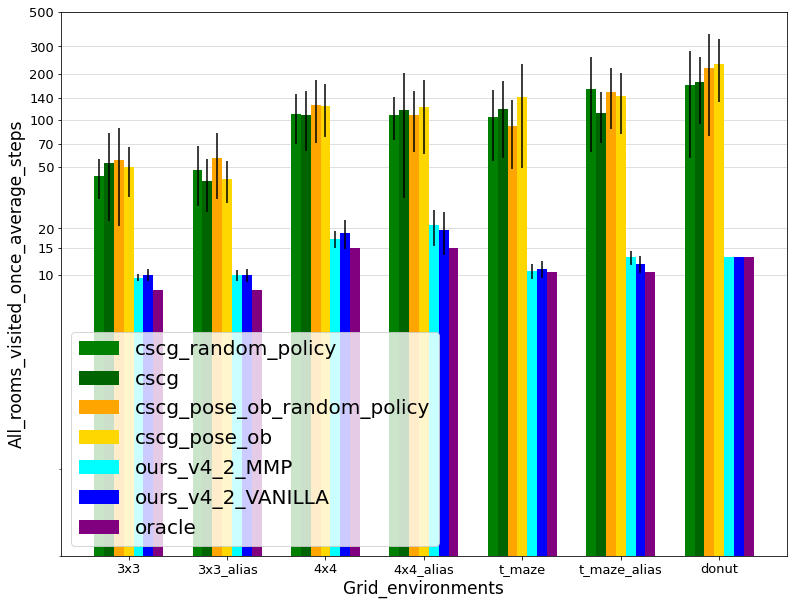

In [140]:
#BAR PLOTS AVERAGE_STEPS
envs_names = [env.replace('grid_', '') for env in envs]
bar_plot_wt_std(average_steps_first_visit, std_steps_first_visit, envs_names, 'All_rooms_visited_once_average_steps', 'Grid_environments', model_names)

### Goal

In [151]:
#GET AVERAGE STEPS REACHING GOAL BY GOAL DIST TO START
# import warnings
warnings.filterwarnings('ignore')
envs = ['grid_3x3', 'grid_3x3_alias', 'grid_4x4', 'grid_4x4_alias' ,'grid_t_maze', 'grid_t_maze_alias', 'grid_donut']#
model_names = ['ours_v4_2_VANILLA','ours_v4_2_VANILLA_wt_prior', #'ours_v4_2_MMP','ours_v4_2_MMP_wt_prior',\
            'cscg_random_policy', 'cscg', 'cscg_pose_ob_random_policy', 'cscg_pose_ob'] 

# envs = ['grid_t_maze' ,'grid_t_maze_alias']
# model_names = ['ours_v4_2_MMP','ours_v4_2_VANILLA', 'ours_v4_2_MMP_wt_prior','ours_v4_2_VANILLA_wt_prior']
nav_type = 'goal'

std_steps = [[0]*(len(envs)) for _ in range(len(model_names))]
average_steps = [[0]*(len(envs)) for _ in range(len(model_names))]
oracle_a_steps = [[0]*(len(envs)) for _ in range(len(model_names))]

for id_m, model_name in enumerate(model_names):
    if '_wt_prior' in model_name:
        load_model = True
        model_name = model_name.replace("_wt_prior","")
    else:
        load_model = False
    
    for id_e, env in enumerate(envs):
        count_runs = [0]*15
        a_failure = 0
        i = -1
        errors = []
        average_steps_model = [[] for _ in range(15)]
        oracle_a_steps_model = [[] for _ in range(15)]
        # Set the path to the folder containing the excel files
        if 'ours' in model_name:
            who = 'ours'
        else:
            who = 'cscg'
        folder_path = 'results/'+ env +'/' + who+'_'+ nav_type +'/'+model_name 
        if 'cscg' in model_name or load_model:
            folder_path+= '.pkl'
        print('folder_path',folder_path)
        df_list, filepath_list = retrieve_df_data_from_folder_path(folder_path,model_name, nav_type, load_model =load_model)
        print('model', model_name, 'env', env,'number of tests:', len(df_list), len(filepath_list))
        for df, filepath in zip(df_list, filepath_list):
            i+=1
           
            # print(df['goal'][0])
            env_setup = GridWorldEnv(env, possible_actions, goal=df['goal'][0])
            _,_ = env_setup.reset(eval(df['poses'][0]))
            output = env_setup.get_short_term_goal()
         
            if output == None: #Goal does not exist in env
                continue
            headers = list(df.columns.values)
            stop_condition_header = [s for s in headers if 'stop_condition_' in s][0]
            if 'ours' in model_name and df['inf_algo'][0] not in model_name:
                print('error, wrong inf algo used')
                print('filepath', filepath)
                continue
            if df[stop_condition_header][0] == True or df[stop_condition_header][0]>0:
                count_runs[output[1]]+=1
                # if 'ours_v4_2_VANILLA' in model_name and output[1]==1 :#df['steps'].iloc[-1]-1 > 20:#output[1]==6:
                #     print('steps:', df['steps'].iloc[-1]-1,' for goal', output[1])
                #     print('filename:', filepath)
                #print(df['poses'][0], output[1], output[2], len(df['steps'])-2)
                #test = get_short_term_goal(env_setup)
                # if output[1] == 0:
                #     print(i,'n_steps', len(df['steps'])-2, 'oracle_steps', output[1])
                # if ( len(df['steps'])-2 - output[1]) >2:
                #     print(filepath)
                # print(filepath_list[i])
                #print('goal', output[1], df['steps'].iloc[-1], output[2], df['poses'][0], df['goal'][0])
                average_steps_model[output[1]].append(df['steps'].iloc[-1]-1) #-1 because we remove the 'STAY' action
                oracle_a_steps_model[output[1]].append(output[1])
    
         
               
            else:
                a_failure+=1 
                errors.append(df['error'][0])
            
                print('failure ', filepath_list[i])
        print('there is ', a_failure, ' failures in this model/env goal reaching')
        print('errors?', errors)
        

        means = [np.mean(np.array(sublist)) for sublist in average_steps_model]
        std_steps[id_m][id_e] = [np.std(np.array(sublist)) for sublist in average_steps_model]
        average_steps[id_m][id_e] = means
        print('model runs in this env:', count_runs)
        print('means', means)
        means = [np.mean(np.array(sublist)) for sublist in oracle_a_steps_model]
        oracle_a_steps[id_m][id_e] = means
        print('oracle means', means)
        print()

        #print('model', model_name,id_m, 'env', env, np.mean(average_steps_model))
        #THIS ASSUMES WE HAVE SQUARED ENVS
#         dim_env = [substring for substring in env.split('_') if 'x' in substring][0]
#         average_steps[-1][id_e] =  int(dim_env[-1]) * 4 -1
# model_names.append('oracle')
print('model[env[n_steps]]')        
print(average_steps)
print(oracle_a_steps)

oracle_a_steps_mean = np.nanmean(np.array(oracle_a_steps), axis=1)
average_steps_mean = np.nanmean(np.array(average_steps), axis=1)

print('model[n_steps]')     
print(average_steps_mean)
print(oracle_a_steps_mean)
# oracle_a_steps[0][0] = 5.0
# print(oracle_a_steps)

folder_path results/grid_3x3/ours_goal/ours_v4_2_VANILLA
model ours_v4_2_VANILLA env grid_3x3 number of tests: 75 75
there is  0  failures in this model/env goal reaching
errors? []
model runs in this env: [7, 23, 25, 14, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
means [0.5714285714285714, 4.043478260869565, 5.68, 3.7142857142857144, 4.333333333333333, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
oracle means [0.0, 1.0, 2.0, 3.0, 4.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

folder_path results/grid_3x3_alias/ours_goal/ours_v4_2_VANILLA
model ours_v4_2_VANILLA env grid_3x3_alias number of tests: 33 33
there is  0  failures in this model/env goal reaching
errors? []
model runs in this env: [3, 10, 12, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
means [0.0, 4.7, 3.25, 7.0, 4.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
oracle means [0.0, 1.0, 2.0, 3.0, 4.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

folder_path results/grid_4x4/ours_goal/ours_v4_2_VANILLA
model ours_v4_2_VA

Tested visualisation with plot line (unreadable)

IndexError: list index out of range

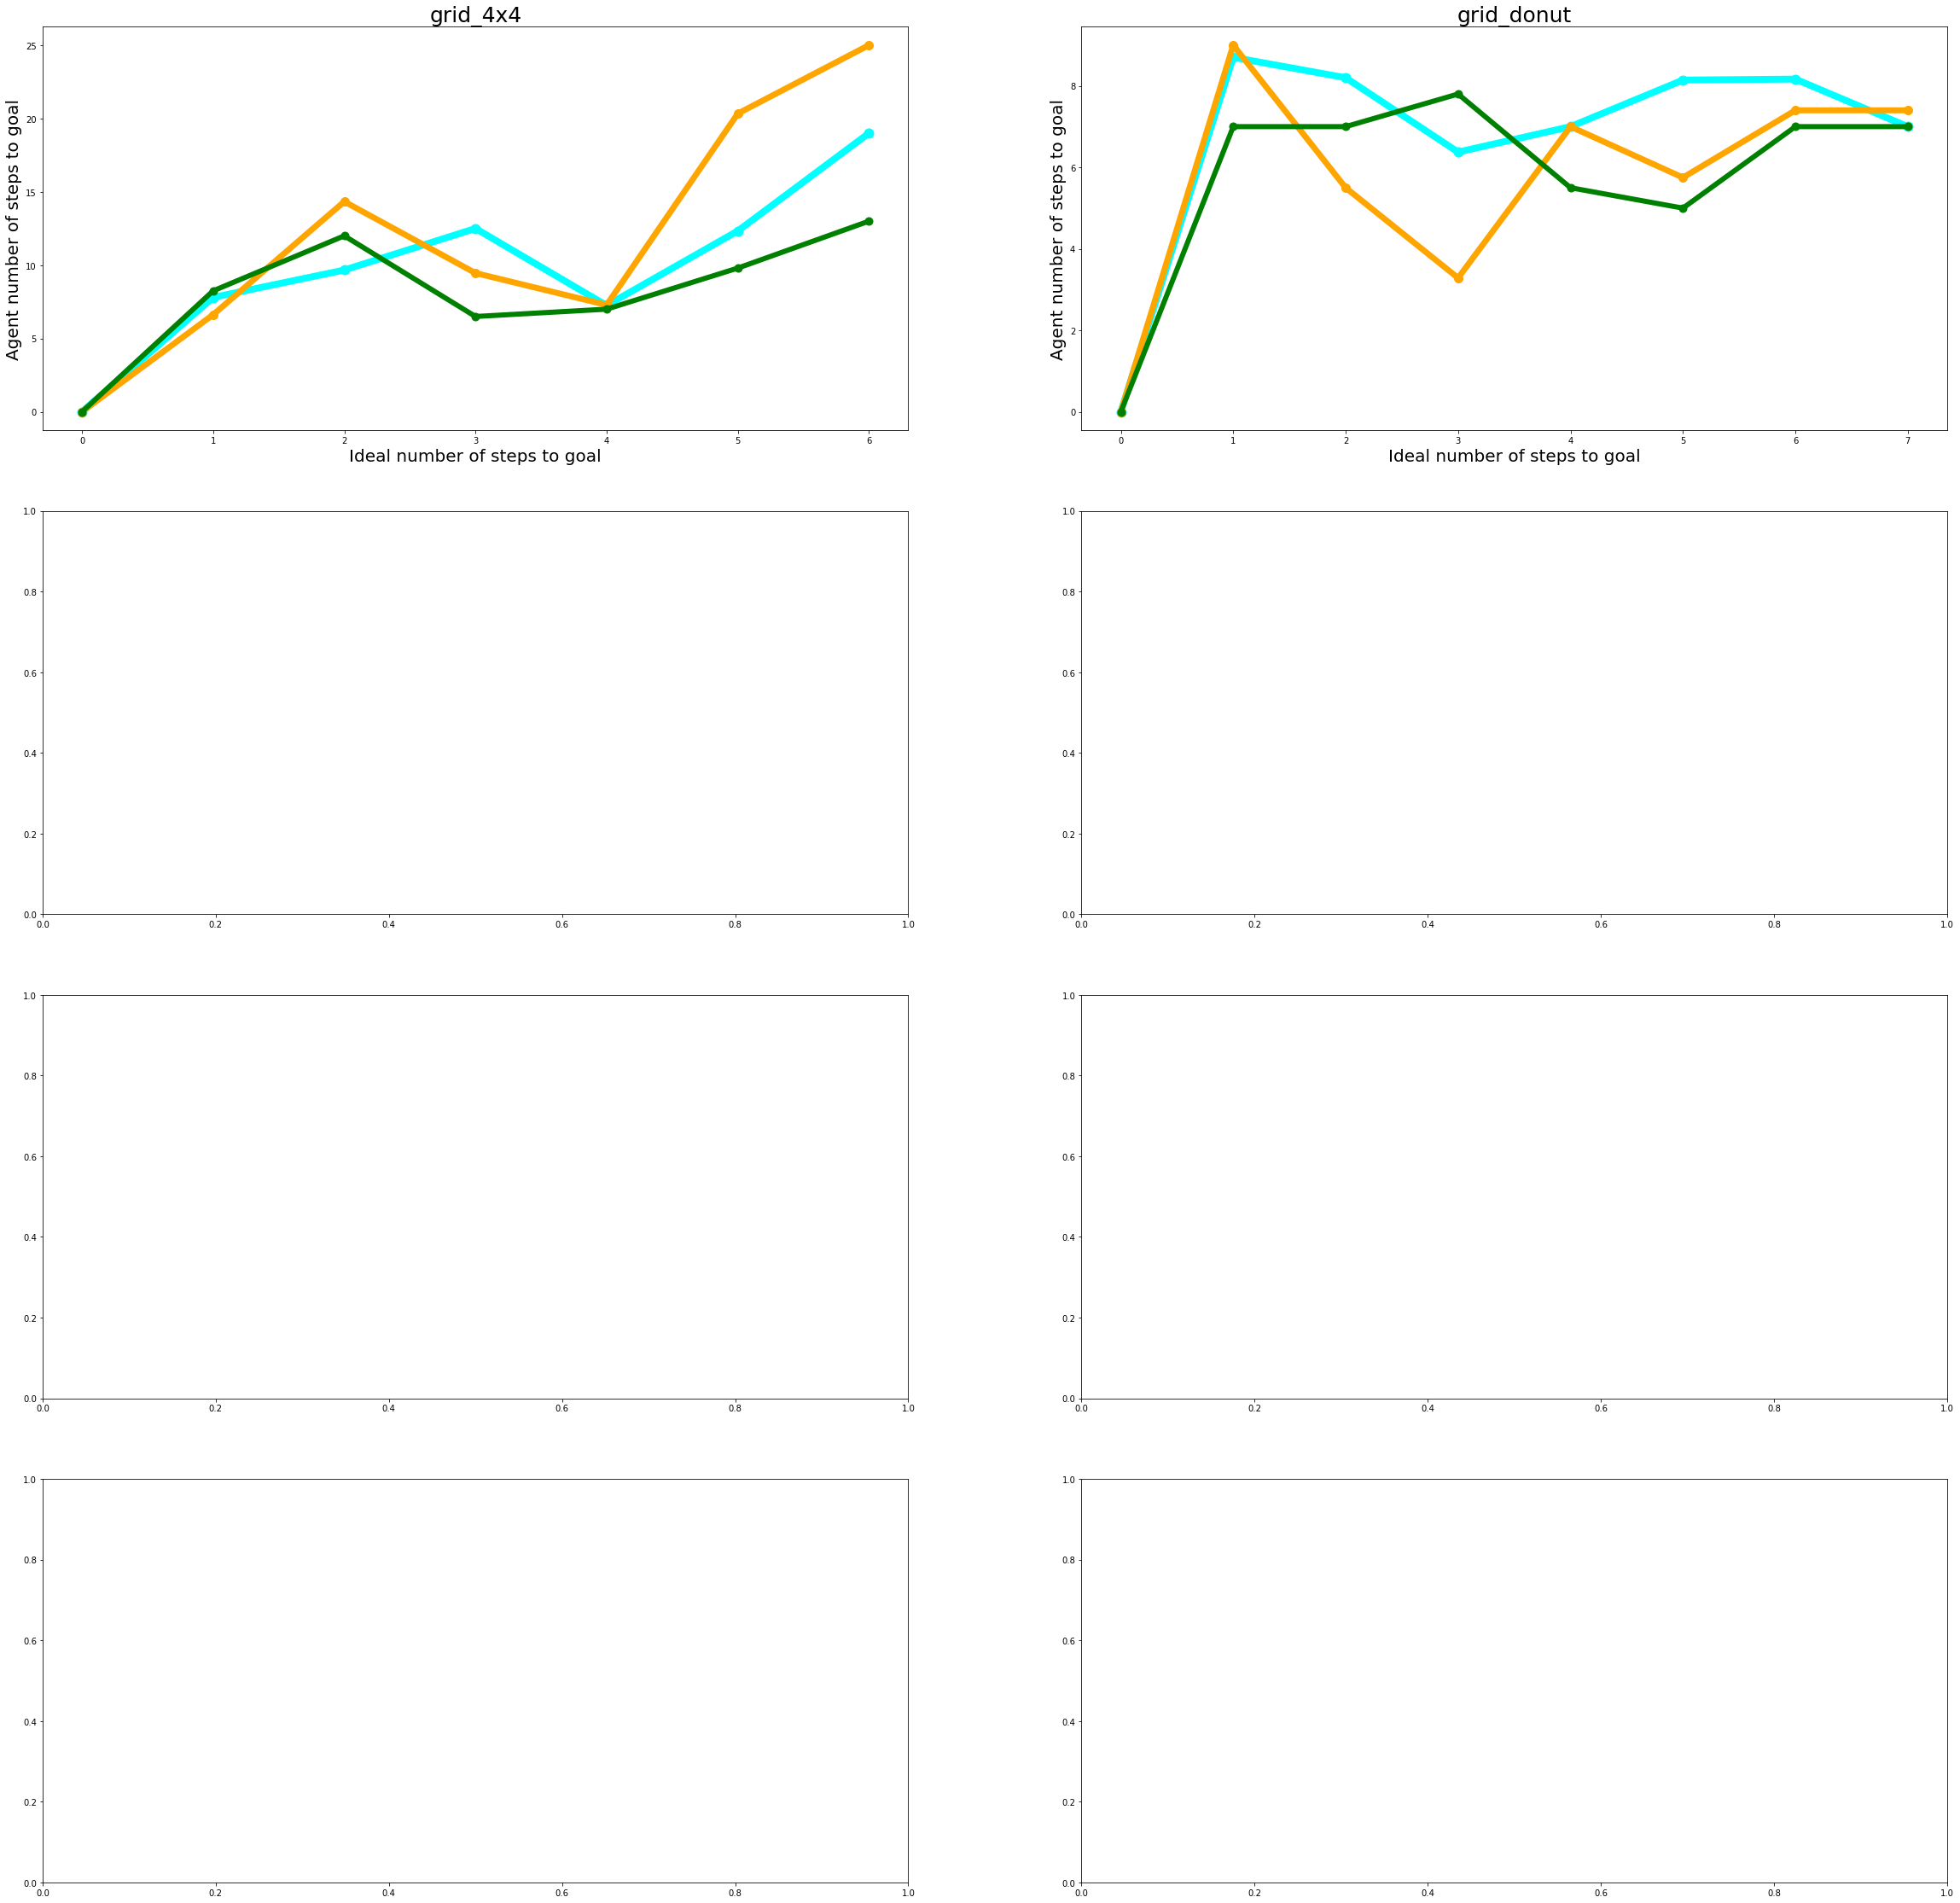

In [ ]:
# fig, axes = plt.subplots(int(len(average_steps[0])/2), int(len(average_steps[0])/2))

on_row = 4
on_col = 2
fig, axes = plt.subplots(on_row, on_col, figsize=(40, 40))
plot_list = [[i, j] for i in range(on_row) for j in range(on_col)]

linewidth = len(average_steps) + 3
for m_id, model_list in enumerate(average_steps):
    for ax_id, env_steps in enumerate(model_list):
        # Filter out nan values
        sublist_filtered = [value for value in env_steps if not np.isnan(value)]
        ax_indexes = plot_list[ax_id]

        line_linewidth = linewidth - (m_id+1)  
        axes[ax_indexes[0], ax_indexes[1]].plot(sublist_filtered, marker='o', \
                                    markersize=line_linewidth+3, linewidth=line_linewidth, color=colors[m_id])

        axes[ax_indexes[0], ax_indexes[1]].set_title(envs[ax_id], fontsize=25)
        axes[ax_indexes[0], ax_indexes[1]].set_xlabel('Ideal number of steps to goal', fontsize=20)
        axes[ax_indexes[0], ax_indexes[1]].set_ylabel('Agent number of steps to goal', fontsize=20)
        
for ax in axes.flat:
    ax.legend(model_names, loc='lower right', fontsize=20)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18) 
    ax.yaxis.set_major_locator(MultipleLocator(1),)
    ax.grid()

plt.show()

    # # Add labels and show the plot
    # plt.xlabel('Index')
    # plt.ylabel('Value')
    # plt.title('Sub-sublist Plots')

    # plt.show()

We average the results by aliased/ non aliased environments

In [152]:
# Identify aliased and non-aliased environments
aliased_indices = [i for i, env in enumerate(envs) if 'alias' in env]
non_aliased_indices = [i for i, env in enumerate(envs) if 'alias' not in env]

# Function to calculate the average steps for a given set of indices
def calculate_average_steps_by_ideal(steps, indices):
    avg_steps_by_ideal = []
    max_length = max(len(model_steps[0]) for model_steps in steps)  # Find the maximum number of ideal steps
    for model_steps in steps:
        avg_steps = []
        for i in range(max_length):
            relevant_steps = []
            for env_id in indices:
                if i < len(model_steps[env_id]) and not np.isnan(model_steps[env_id][i]):
                    relevant_steps.append(model_steps[env_id][i])
            if relevant_steps:
                avg = np.mean(relevant_steps)
            else:
                avg = np.nan
            avg_steps.append(avg)
        avg_steps_by_ideal.append(avg_steps)
    return avg_steps_by_ideal



# Calculate average steps for aliased and non-aliased environments
aliased_avg_steps = calculate_average_steps_by_ideal(average_steps, aliased_indices)
non_aliased_avg_steps = calculate_average_steps_by_ideal(average_steps, non_aliased_indices)

aliased_std_steps = calculate_average_steps_by_ideal(std_steps, aliased_indices)
non_aliased_std_steps = calculate_average_steps_by_ideal(std_steps, non_aliased_indices)

# Display the results
for i, model_name in enumerate(model_names):
    print(f"{model_name}:")
    print(f"  Aliased Avg Steps: {aliased_avg_steps[i]}")
    print(f"  Non-Aliased Avg Steps: {non_aliased_avg_steps[i]}\n")


ours_v4_2_VANILLA:
  Aliased Avg Steps: [0.0, 5.205555555555555, 5.061111111111111, 6.071428571428572, 5.333333333333333, 7.5, nan, nan, nan, nan, nan, nan, nan, nan, nan]
  Non-Aliased Avg Steps: [0.14285714285714285, 5.621980676328502, 6.345641025641025, 5.567032967032967, 6.575757575757575, 6.222222222222222, 9.25, 7.0, nan, nan, nan, nan, nan, nan, nan]

ours_v4_2_VANILLA_wt_prior:
  Aliased Avg Steps: [0.0, 1.5, 2.1333333333333333, 3.111111111111111, 4.0, 5.0, nan, nan, nan, nan, nan, nan, nan, nan, nan]
  Non-Aliased Avg Steps: [0.0, 1.0, 2.0, 3.0, 4.0, 5.333333333333333, 7.0, 8.0, nan, nan, nan, nan, nan, nan, nan]

cscg_random_policy:
  Aliased Avg Steps: [0.0, 2.253968253968254, 5.0, 6.2444444444444445, 6.733333333333333, 9.75, nan, nan, nan, nan, nan, nan, nan, nan, nan]
  Non-Aliased Avg Steps: [0.0, 1.0, 2.2, 3.0277777777777777, 4.75, 5.555555555555556, 6.4, 8.0, nan, nan, nan, nan, nan, nan, nan]

cscg:
  Aliased Avg Steps: [1.0648148148148149, 1.8095238095238095, 3.771825

Plot the averaged alias/ non aliased number of steps

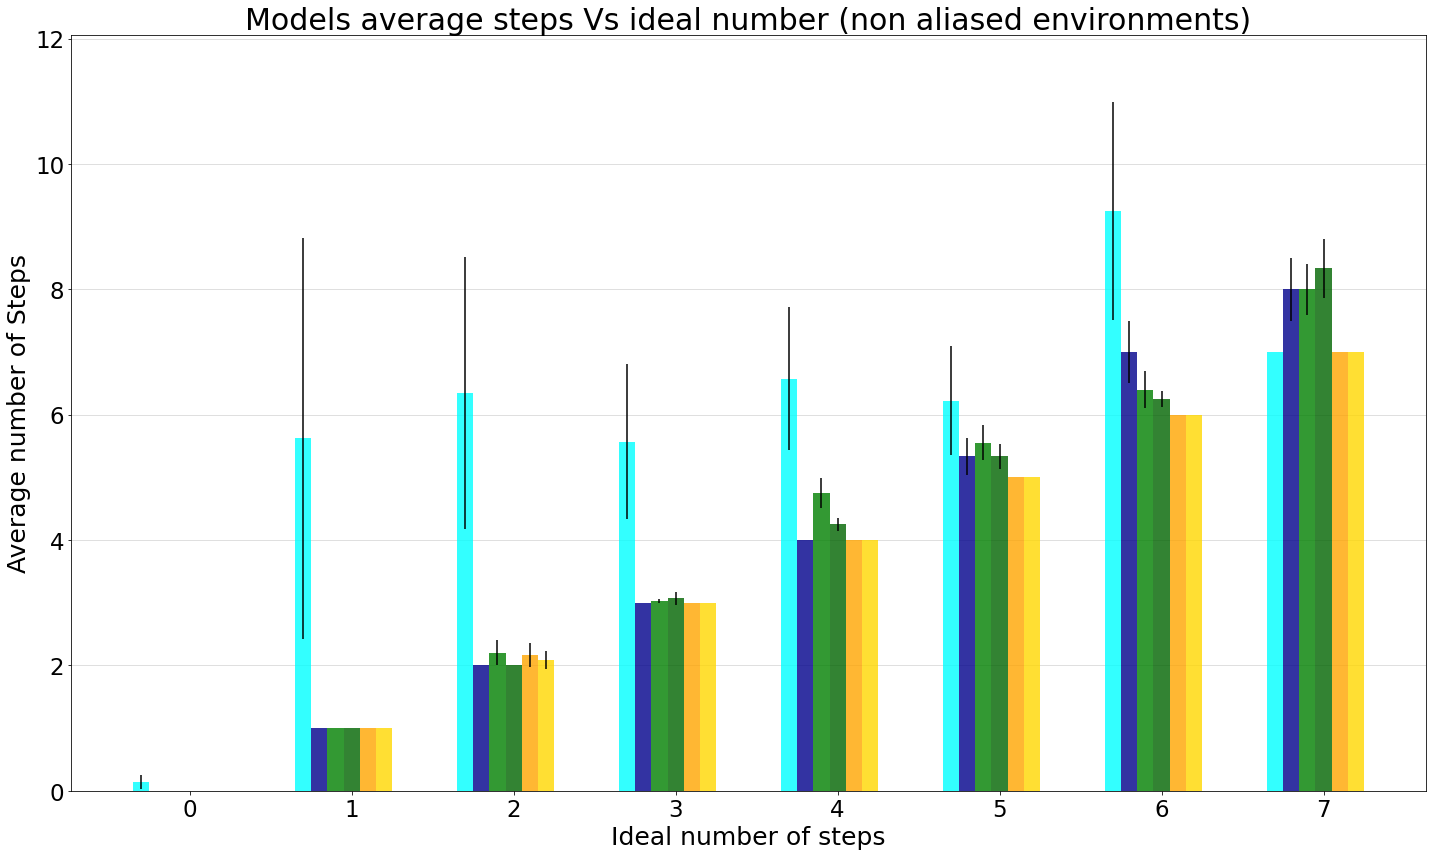

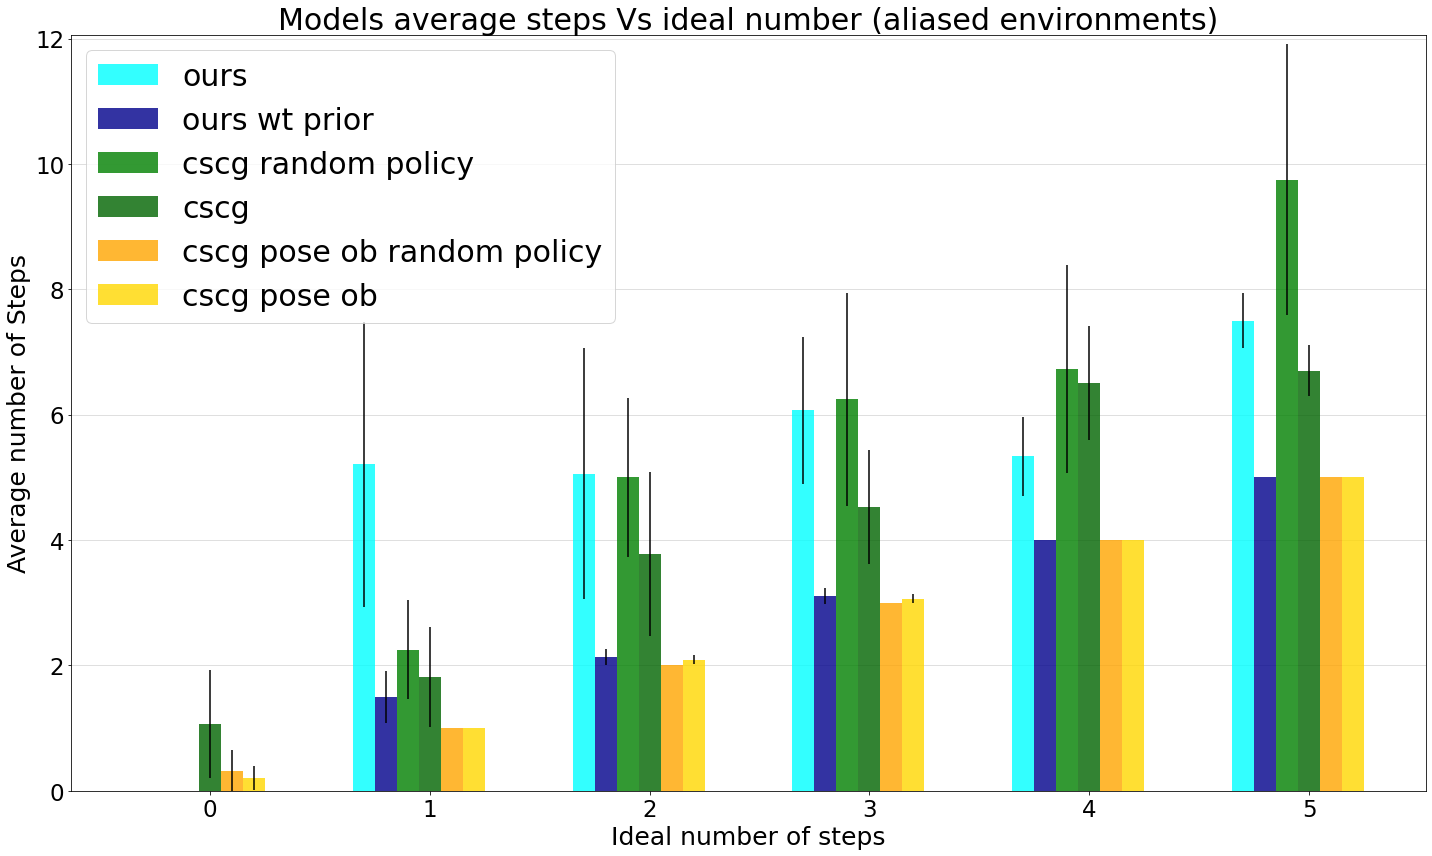

In [173]:
# Plotting the bar plot
import copy
colors = ['cyan', 'darkblue', 'green', 'darkgreen', 'orange', 'gold', ]



bar_width = 0.1
opacity = 0.8

modif_model_names = [name.replace('_v4_2_VANILLA', '') for name in model_names]
modif_model_names = [name.replace('_', ' ') for name in modif_model_names]
# Plot bars for each model
for i in range(2):
    fig, ax = plt.subplots(figsize=(20, 12))
    if i == 1 :
        avg_steps = copy.deepcopy(aliased_avg_steps)
        avg_std_steps = copy.deepcopy(aliased_std_steps) 
        env_type = 'aliased'
    else:
        avg_steps = copy.deepcopy(non_aliased_avg_steps) 
        avg_std_steps = copy.deepcopy(non_aliased_std_steps) 
        env_type = 'non aliased'
    for m_id, model_name in enumerate(modif_model_names):
        space= m_id-3
        model_avg_steps = [value for value in avg_steps[m_id] if not np.isnan(value)]
        model_avg_std_steps = [value/2 for value in avg_std_steps[m_id] if not np.isnan(value)]
        ideal_steps = list(range(len(model_avg_steps)))  # x-axis values
        ideal_steps =  [p + space*0.1 for p in ideal_steps]

        ax.bar(
            ideal_steps,#[x + i * bar_width for x in ideal_steps], 
            model_avg_steps, 
            color = colors[m_id],
            yerr=model_avg_std_steps, 
            width=bar_width,
            alpha=opacity,
            label=model_name,
            zorder=2
        )
        # ax.bar(ideal_steps,sublist_filtered, color=colors[m_id], yerr=std_filtered,  width=0.1, label=model_name, zorder=2)

    # Add labels and legend
    # ax.set_xlabel('Ideal Number of Steps')
    # ax.set_ylabel('Average Number of Steps')
    # ax.set_title(f'Models average steps Vs ideal amount ({env_type} Environments)')
    # ax.set_xticks([x + bar_width * (len(model_names) / 2) for x in ideal_steps])
    ax.set_xticks([0,1,2,3,4,5])
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)
    plt.ylim(0,12.05)
    plt.title(f'Models average steps Vs ideal number ({env_type} environments)', fontsize=30)
    plt.xlabel('Ideal number of steps', fontsize=25)
    plt.ylabel('Average number of Steps', fontsize=25)
    plt.tight_layout()
    # ax.set_xticklabels(ideal_steps)
    if i == 1:
        plt.legend(modif_model_names, loc='upper left', fontsize=30)
    else:
        plt.xticks([0,1,2,3,4,5,6,7])
    plt.grid(axis='y', alpha=0.5, zorder=0)
    plt.tight_layout()
    plt.savefig(f'figures/steps_to_goal_averaged_{env_type}_envs')
    plt.show()

All envs plotted

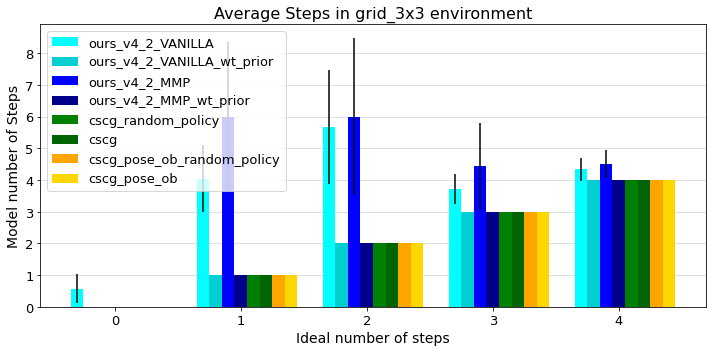

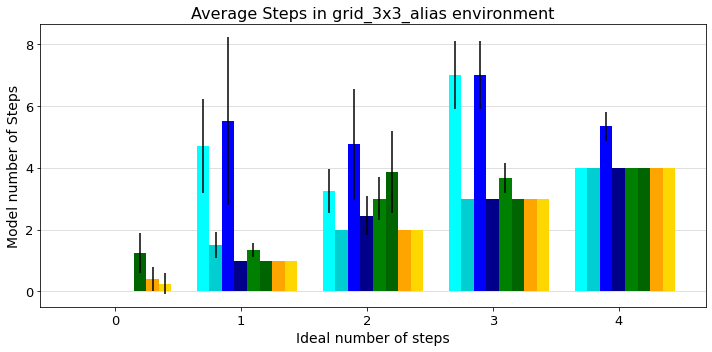

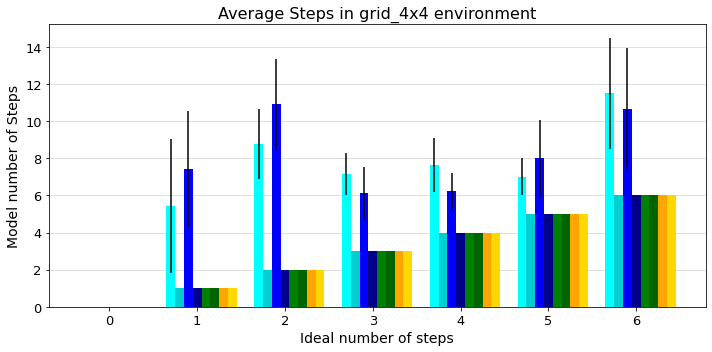

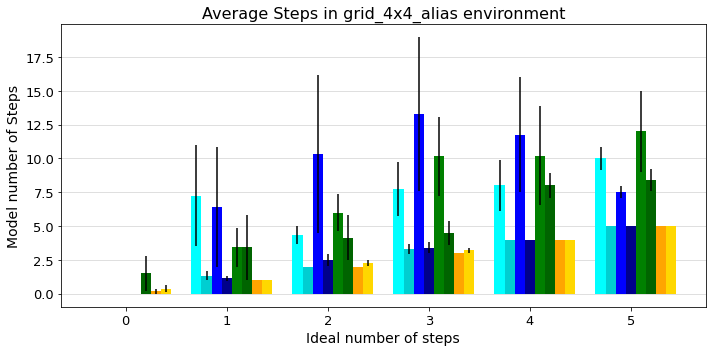

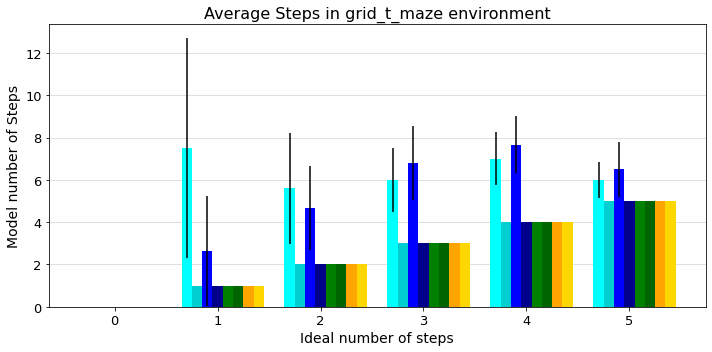

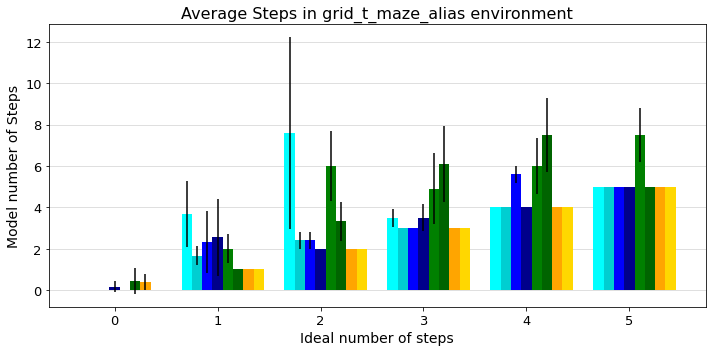

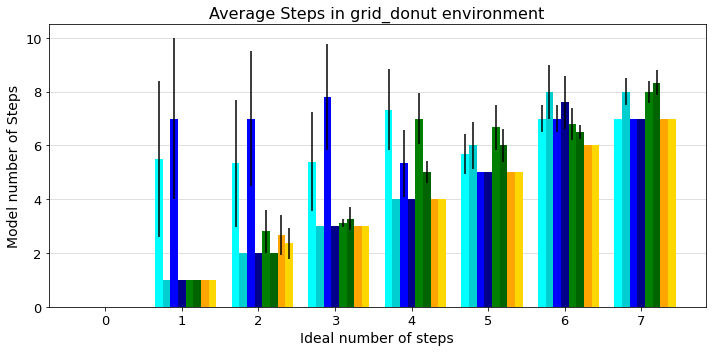

In [164]:
colors = ['cyan', 'darkturquoise', 'blue' ,'darkblue', 'green', 'darkgreen', 'orange', 'gold', ]
#colors = ['cyan', 'green', 'pink', 'orange', 'blue', 'grey']
for env_id, env_name in enumerate(envs):
    plt.figure(figsize=(10, 5))
    plt.title(f'Average Steps in {env_name} environment', fontsize=16)
    plt.xlabel('Ideal number of steps', fontsize=14)
    plt.ylabel('Model number of Steps', fontsize=14)
    for m_id, model_name in enumerate(model_names):  
        sublist_filtered = [value for value in average_steps[m_id][env_id] if not np.isnan(value)]
        std_filtered = [value/2 for value in std_steps[m_id][env_id] if not np.isnan(value)] 
        perfect = list(range(len(sublist_filtered)))
        space= m_id-3
        perfect = [ p + space*0.1 for p in perfect]
        
        plt.bar(perfect,sublist_filtered, color=colors[m_id], yerr=std_filtered,  width=0.1, label=model_name, zorder=2) 
    plt.grid(axis='y', alpha=0.5, zorder=0)
    if env_id == 0 :
        plt.legend(model_names, loc='upper left', fontsize=13)#, bbox_to_anchor=(1.3, 0.99)) 
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.tight_layout()
    plt.savefig(f'figures/steps_to_goal_in_env_{env_name}')
    plt.show()
    

## Obstacle avoidance

Plot the paths the agent took deepending on the lookahead. Results come from table steps_to_goal_grids.xslx

Tried Heatmap (terrible)

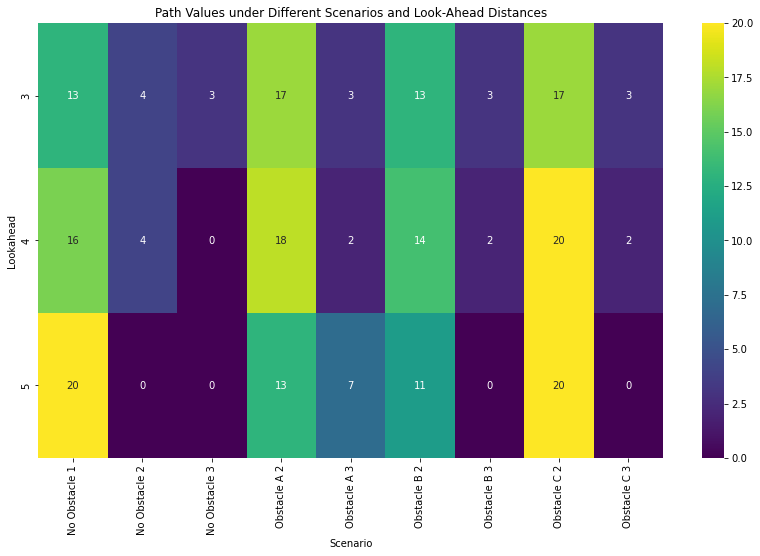

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#1,2,3 -> paths taken
# 3,4,5 -> lookahead
# Data
data = {
    'Lookahead': [3, 4, 5],
    'No Obstacle 1': [13, 16, 20],
    'No Obstacle 2': [4, 4, 0],
    'No Obstacle 3': [3, 0, 0],
    'Obstacle A 2': [17, 18, 13],
    'Obstacle A 3': [3, 2, 7],
    'Obstacle B 2': [13, 14, 11],
    'Obstacle B 3': [3, 2, 0],
    'Obstacle C 2': [17, 20, 20],
    'Obstacle C 3': [3, 2, 0]
}

df = pd.DataFrame(data)

# Melt the dataframe
df_melt = df.melt(id_vars='Lookahead', var_name='Scenario', value_name='Value')

# Create the pivot table for the heatmap
pivot_table = df_melt.pivot_table(index='Lookahead', columns='Scenario', values='Value')

# Create the heatmap
plt.figure(figsize=(14, 8))
heatmap = sns.heatmap(pivot_table, annot=True, fmt="d", cmap='viridis')
plt.title('Path Values under Different Scenarios and Look-Ahead Distances')
plt.show()


Tried lines (terrible)

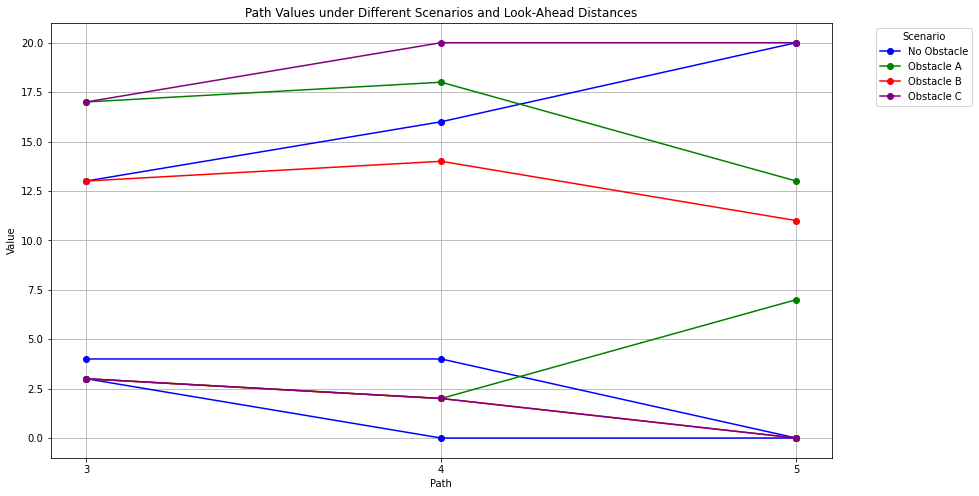

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    'Path': [3, 4, 5],
    'No Obstacle 1': [13, 16, 20],
    'No Obstacle 2': [4, 4, 0],
    'No Obstacle 3': [3, 0, 0],
    'Obstacle A 2': [17, 18, 13],
    'Obstacle A 3': [3, 2, 7],
    'Obstacle B 2': [13, 14, 11],
    'Obstacle B 3': [3, 2, 0],
    'Obstacle C 2': [17, 20, 20],
    'Obstacle C 3': [3, 2, 0]
}

df = pd.DataFrame(data)

# Set the Path as the index
df.set_index('Path', inplace=True)

# Creating a dictionary to map scenarios to colors
colors = {
    'No Obstacle': 'blue',
    'Obstacle A': 'green',
    'Obstacle B': 'red',
    'Obstacle C': 'purple'
}

# Create a dictionary to map columns to the grouped scenarios
column_to_scenario = {
    'No Obstacle 1': 'No Obstacle',
    'No Obstacle 2': 'No Obstacle',
    'No Obstacle 3': 'No Obstacle',
    'Obstacle A 2': 'Obstacle A',
    'Obstacle A 3': 'Obstacle A',
    'Obstacle B 2': 'Obstacle B',
    'Obstacle B 3': 'Obstacle B',
    'Obstacle C 2': 'Obstacle C',
    'Obstacle C 3': 'Obstacle C'
}

# Plotting the dot plot
plt.figure(figsize=(14, 8))

# Keep track of which scenarios we've already added to the legend
handled_scenarios = set()

for column in df.columns:
    scenario = column_to_scenario[column]
    color = colors[scenario]
    if scenario not in handled_scenarios:
        plt.plot(df.index, df[column], 'o-', label=scenario, color=color)
        handled_scenarios.add(scenario)
    else:
        plt.plot(df.index, df[column], 'o-', color=color)

plt.title('Path Values under Different Scenarios and Look-Ahead Distances')
plt.xlabel('Path')
plt.ylabel('Value')
plt.xticks(df.index)
plt.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


Plotted average paths on the map. Nice (those are averaged paths )

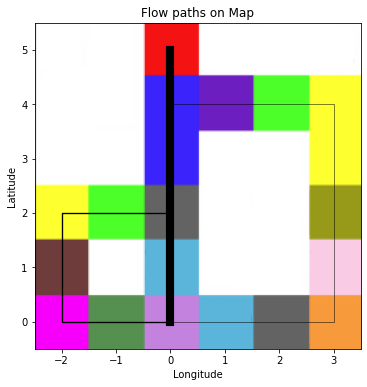

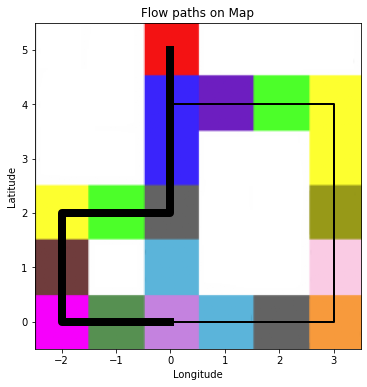

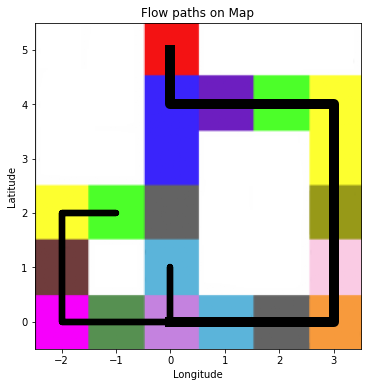

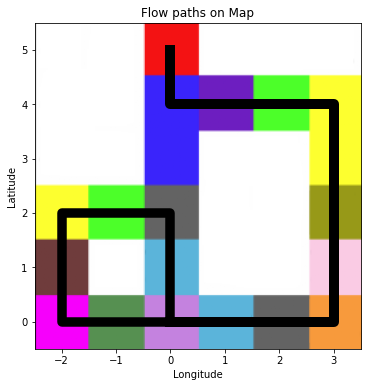

In [46]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Define coordinates for each path
path_1 = [(0, 0), (0, 1), (0, 2), (0, 5)]  # Straight line up
path_2 = [(0, 0),(-2, 0), (-2, 2), 
          (0, 2), (0, 5)]  # Loop on the left
path_3 = [(0, 0), (3, 0),
          (3, 4), (0, 4), (0, 5)]  # Loop on the right


path_2_B = [(0, 0),(0, 1), (0, 0), (-2, 0), (-2, 2), 
          (-1, 2), (-2, 2),(-2, 0),(0, 0)]

path_2_C = [(0, 0), (0, 2),(-2, 2), (-2, 0),(0, 0)] 
background_img = mpimg.imread('/home/idlab332/Pictures/higher_level_nav/cross_tunnel.png')

tot = 60
path1 = [13+16+20, 0,0,0]
path2 = [4+4, 17+18+13,13+14+11,17+20+20]
path3 = [3, 3+2+7,20+20+20,20+20+20 ]
# path4 = [0,0,13+14+11, ]
for i in range(len(path2)):
    # Create the plot
    plt.figure(figsize=(8, 6))

    # Unzip coordinates for plotting
    x1, y1 = zip(*path_1)
    if i==0:
        x2, y2 = zip(*path_2)
    elif i==2:
        x2, y2 = zip(*path_2_B)
    elif i==3:
        x2, y2 = zip(*path_2_C)
    x3, y3 = zip(*path_3)

    # Plot the background image
    plt.imshow(background_img, extent=[-2.5, 3.5, -0.5, 5.5])  # Adjust extent as per your image and coordinates

    
    plt.plot(x1, y1, linewidth= 10*path1[i]/tot, color='black')
    plt.plot(x2, y2,linewidth= 10*path2[i]/tot,color='black')
    plt.plot(x3, y3,linewidth= 10*path3[i]/tot,color='black')

    # Add labels and legend
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Flow paths on Map')
    # plt.legend()

    # Show the plot
    plt.grid(False)
    plt.gca().set_aspect('equal', adjustable='box')  # Set equal aspect ratio
    plt.show()
